In [1]:
import numpy as np
from helpers_preprocessing import *

#### The code loads the datasets, identifies and removes constant features, and prepares the data for modeling by ensuring both training and test sets are cleaned and aligned.

In [2]:
X_TRAIN_PATH = 'dataset/x_train.csv'
Y_TRAIN_PATH = 'dataset/y_train.csv'
X_TEST_PATH = 'dataset/x_test.csv'

# Read headers
x_train_header = read_header(X_TRAIN_PATH)
y_train_header = read_header(Y_TRAIN_PATH)
x_test_header = read_header(X_TEST_PATH)

# Load datasets
x_train = load_data(X_TRAIN_PATH)
y_train = load_data(Y_TRAIN_PATH)
x_test = load_data(X_TEST_PATH)

# Identify constant columns in x_train
constant_columns = find_constant_columns(x_train)

# Drop constant columns from both train and test datasets
x_train_cleaned, x_train_header_cleaned = drop_columns(x_train, x_train_header, constant_columns)
x_test_cleaned, x_test_header_cleaned = drop_columns(x_test, x_test_header, constant_columns)

# Inspect the results
print("Original x_train shape:", x_train.shape)
print("Cleaned x_train shape:", x_train_cleaned.shape)
print("Original x_test shape:", x_test.shape)
print("Cleaned x_test shape:", x_test_cleaned.shape)

Original x_train shape: (328135, 322)
Cleaned x_train shape: (328135, 316)
Original x_test shape: (109379, 322)
Cleaned x_test shape: (109379, 316)


#### Converts the _STATE categorical feature into one-hot encoded dummy variables, removes the original _STATE column, appends the new dummy variables to both datasets, and updates headers to reflect these changes, preparing the data for modeling with state information included numerically.

In [3]:
# Extract the _STATE column from x_train_cleaned and x_test_cleaned
state_column_index = x_train_header_cleaned.index("_STATE")  # Get the index of the _STATE column
state_train = x_train_cleaned[:, state_column_index]
state_test = x_test_cleaned[:, state_column_index]

# Identify unique states
unique_states = np.unique(state_train)

# Create dummy variables for both train and test
dummy_train = create_dummy_variables(state_train, unique_states)
dummy_test = create_dummy_variables(state_test, unique_states)

# Remove the original _STATE column from x_train_cleaned and x_test_cleaned
x_train_cleaned = np.delete(x_train_cleaned, state_column_index, axis=1)
x_test_cleaned = np.delete(x_test_cleaned, state_column_index, axis=1)

# Append the dummy variables to the original dataset
x_train_cleaned = np.hstack((x_train_cleaned, dummy_train))
x_test_cleaned = np.hstack((x_test_cleaned, dummy_test))

# Add dummy variable column names to the headers
dummy_headers = [f"STATE_{int(state)}" for state in unique_states]  # Create dummy headers like "STATE_1", "STATE_2", etc.
x_train_header_cleaned = [col for col in x_train_header_cleaned if col != "_STATE"] + dummy_headers
x_test_header_cleaned = [col for col in x_test_header_cleaned if col != "_STATE"] + dummy_headers

# Print shapes
print(x_train_cleaned.shape)

(328135, 368)


#### This code snippet removes columns from `x_train_cleaned` and `x_test_cleaned` that have more than 60% missing values. It updates the corresponding headers and prints the shape of `x_train_cleaned` after the removal, ensuring data integrity and reducing noise from incomplete data columns.

In [4]:
# Remove columns with more than 60% missing values from x_train_cleaned and x_test_cleaned
missing_values_threshold = 0.6
columns_to_drop = []
for i in range(x_train_cleaned.shape[1]):
    missing_values = np.isnan(x_train_cleaned[:, i]).sum() / x_train_cleaned.shape[0]
    if missing_values > missing_values_threshold:
        columns_to_drop.append(i)

x_train_cleaned = np.delete(x_train_cleaned, columns_to_drop, axis=1)
x_test_cleaned = np.delete(x_test_cleaned, columns_to_drop, axis=1)

# Remove the same columns from the headers
x_train_header_cleaned = [col for i, col in enumerate(x_train_header_cleaned) if i not in columns_to_drop]
x_test_header_cleaned = [col for i, col in enumerate(x_test_header_cleaned) if i not in columns_to_drop]

# Print shapes
print(x_train_cleaned.shape)

(328135, 241)


#### Processing of "GENHLTH". Create dummy variables for this feature and labels them with `gen_health_dummy_labels`. The function then removes the original "GENHLTH" column from both the dataset and its headers, updating them accordingly. This process is applied to both training and test data to ensure consistency and prepare the data for further analysis or modeling tasks.

In [5]:
gen_health_dummy_labels = [f"GENHLTH_{i}" for i in range(1, 6)]

x_train_cleaned, x_train_header_cleaned = process_health_feature(
    x_train_cleaned, x_train_header_cleaned, "GENHLTH",
    create_gen_health_dummy_variables, gen_health_dummy_labels
)

x_test_cleaned, x_test_header_cleaned = process_health_feature(
    x_test_cleaned, x_test_header_cleaned, "GENHLTH",
    create_gen_health_dummy_variables, gen_health_dummy_labels
)

#### This code snippet applies replacements to specific columns ("PHYSHLTH", "MENTHLTH", "POORHLTH") in `x_train_cleaned` and `x_test_cleaned`. Values `88` are replaced with `0`, while `77` and `99` are replaced with `NaN`. Categorical columns, identified as those with up to 8 distinct values, handle values `7` (Don’t Know/Not Sure) and `9` (Refused) without creating dummy variables for them.

All catergorical variables will be treated with the following sell. Categorical columns are the ones with <= 8 distinct values. The values 7 and 9 always mean Don’t know/Not Sure and Refused, respectively. No need to create a dummy variable for them

In [6]:
# Target columns to modify
target_columns = ["PHYSHLTH", "MENTHLTH", "POORHLTH"]
replacement_values = {88: 0, 77: np.nan, 99: np.nan}

# Get column indices for the target columns
target_indices = [x_train_header_cleaned.index(col) for col in target_columns]

# Apply replacement to train and test datasets
x_train_cleaned = replace_values(x_train_cleaned, target_indices, replacement_values)
x_test_cleaned = replace_values(x_test_cleaned, target_indices, replacement_values)

#### This function, `process_categorical_columns`, processes both training and testing datasets by first converting them to float type. It identifies categorical columns using `identify_categorical_columns`, then iteratively creates dummy variables for each identified categorical column using `create_dummy_variables_for_column`. Finally, it returns the cleaned training and testing datasets along with their updated headers, ensuring consistency in data type and format for further analysis or modeling tasks. (could take some time)

In [7]:
# Process the datasets
x_train_cleaned, x_test_cleaned, x_train_header_cleaned, x_test_header_cleaned = process_categorical_columns(
    x_train_cleaned, x_test_cleaned, x_train_header_cleaned, x_test_header_cleaned)

#### This code snippet fills all NaN values in x_train_cleaned and x_test_cleaned with the median value of each respective column. This ensures missing data is replaced with a robust central value, preparing the datasets for analysis or modeling by reducing the impact of missing values on statistical computations and algorithms.

In [8]:
# Apply the function to your datasets
x_train_cleaned, x_test_cleaned = fill_nans_with_median(x_train_cleaned, x_test_cleaned)
print(x_train_cleaned.shape)

(328135, 402)


#### This code defines functions to extract IDs and features from a dataset, create a mapping of IDs to target values, validate the data, compute the correlation matrix, filter features by a specified correlation threshold, and sort them accordingly. It concludes by printing the shape of the filtered features and their sorted order.

In [15]:
# Extract IDs and features from x_train_cleaned
x_train_ids, x_train_features = extract_ids_and_features(x_train_cleaned)
feature_headers = x_train_header_cleaned[1:]

# Create mapping from Id to y_value
y_mapping = create_y_mapping(y_train)

# Map y_values to x_train_ids
aligned_y_values = align_y_values(x_train_ids, y_mapping)

# Validate the data
validate_data(x_train_features, aligned_y_values)

# Compute the correlation matrix
corr_matrix = compute_correlation_matrix(x_train_features, aligned_y_values)

# Extract correlations between features and y
corr_to_y = corr_matrix[-1, :-1]  # Exclude the correlation of y with itself

# Set the correlation threshold
correlation_threshold = 0.03

# Filter features based on the correlation threshold
columns_to_keep, filtered_feature_headers = filter_features_by_correlation(corr_to_y, feature_headers, correlation_threshold)

# Filter the features in x_train_features
x_train_filtered_features = x_train_features[:, columns_to_keep]

# Update the aligned correlations
filtered_corr = corr_to_y[columns_to_keep]

# Sort features by correlation
sorted_features, sorted_corr = sort_features_by_correlation(filtered_corr, filtered_feature_headers)

# Check the shapes or the filtered results as needed
print("Filtered features shape:", x_train_filtered_features.shape)
print("Sorted features by correlation:", sorted_features)

#### This code uses Matplotlib to create a bar plot visualizing the correlation coefficients of features with a target variable. Each feature is represented on the x-axis, with its corresponding correlation value displayed on the y-axis, colored blue for positive correlations and red for negative correlations. The plot is formatted for clarity, including rotated x-tick labels and a grid for easier reading.

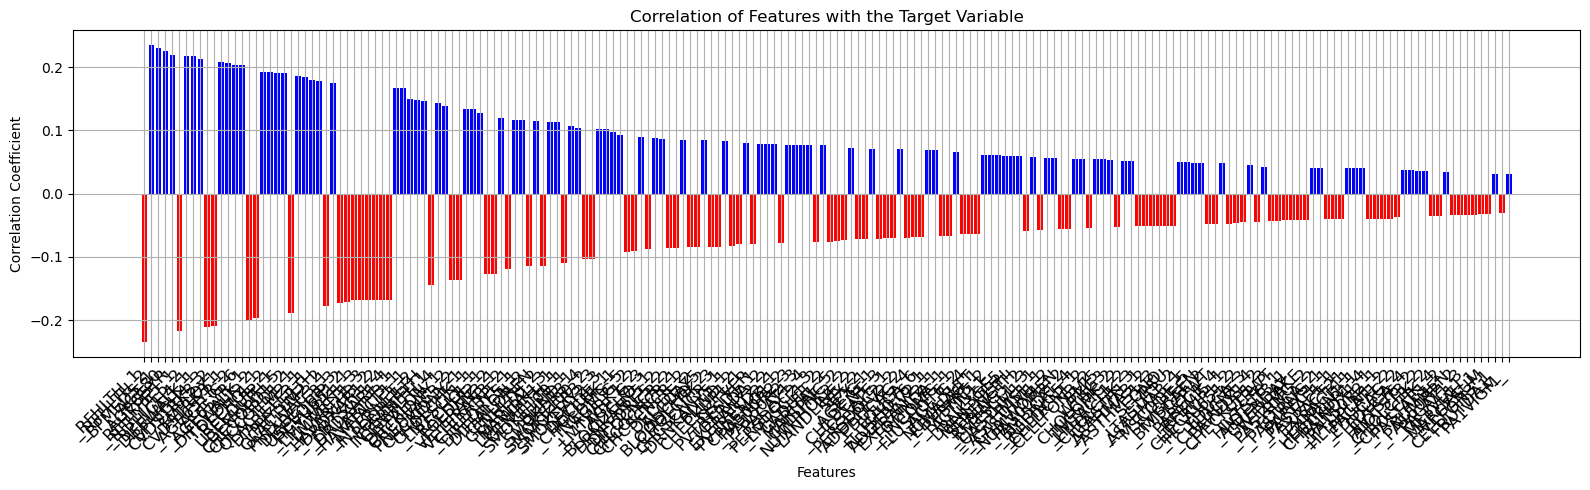

In [11]:
import matplotlib.pyplot as plt

# Plot the correlation
fig, ax = plt.subplots(figsize=(16, 5))
x_labels = []
corr_values = []

for feature, corr_value in zip(sorted_features, sorted_corr):
    ax.bar(feature, corr_value, color='b' if corr_value > 0 else 'r')
    x_labels.append(feature)
    corr_values.append(corr_value)

# Set the tick labels to the features
ax.set_xticks(range(len(x_labels)))
ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=12)
ax.set_ylabel("Correlation Coefficient")
ax.set_xlabel("Features")
ax.set_title("Correlation of Features with the Target Variable")
ax.grid(True)
plt.tight_layout()
plt.show()

#### This code defines functions to extract IDs and features from a test dataset, validate feature headers against a training dataset, filter features, and reconstruct the cleaned datasets. It ensures consistency between training and testing data, updates headers, and prints the count of features removed due to low correlation.

In [12]:
def extract_ids_and_features_new(data):
    """Extracts the Id column and features from the dataset, reshaping Ids."""
    ids = data[:, 0].reshape(-1, 1)  # Extract and reshape the Id column
    features = data[:, 1:]  # Extract the features (excluding Id column)
    return ids, features

# Extract Ids and features from x_test_cleaned
x_test_ids, x_test_features = extract_ids_and_features_new(x_test_cleaned)

# Validate feature headers
validate_feature_headers(x_test_header_cleaned, feature_headers)

# Filter features in test data
x_test_filtered_features = filter_test_features(x_test_features, columns_to_keep)

# Reconstruct x_train_cleaned and x_test_cleaned with the filtered features and Id column
x_train_cleaned = reconstruct_cleaned_data(x_train_ids, x_train_filtered_features)
x_test_cleaned = reconstruct_cleaned_data(x_test_ids, x_test_filtered_features)

# Update the headers to include 'Id' and the filtered feature names
x_train_header_cleaned = update_headers(filtered_feature_headers)
x_test_header_cleaned = update_headers(filtered_feature_headers)

# Count and print the number of features removed
num_features_removed = len(feature_headers) - len(filtered_feature_headers)
print(f"Number of features removed due to low correlation: {num_features_removed}")
print(f"Number of features kept: {len(filtered_feature_headers)}")

Number of features removed due to low correlation: 205
Number of features kept: 196


#### This code snippet defines functions for extracting IDs and features from datasets, computing feature statistics (min, max, and range), scaling features using min-max normalization, and reattaching IDs to the scaled features. It processes both training and testing datasets to ensure consistent scaling while preserving the ID information.

In [13]:
# Extract Ids and features from x_train_cleaned and x_test_cleaned
x_train_ids, x_train_features = extract_ids_and_features(x_train_cleaned)
x_test_ids, x_test_features = extract_ids_and_features(x_test_cleaned)

# Compute min, max, and ranges from the training features
feature_mins, feature_maxs, feature_ranges = compute_feature_stats(x_train_features)

# Scale the training and testing features
x_train_scaled_features = scale_features(x_train_features, feature_mins, feature_ranges)
x_test_scaled_features = scale_features(x_test_features, feature_mins, feature_ranges)

# Reattach the Id column to the scaled features
x_train_cleaned = reattach_ids(x_train_scaled_features, x_train_ids)
x_test_cleaned = reattach_ids(x_test_scaled_features, x_test_ids)

#### This code saves the cleaned training and testing datasets to CSV files, writing the headers followed by the data rows for both x_train_cleaned and x_test_cleaned.

In [13]:
# Save cleaned data with headers
with open('dataset/x_train_cleaned.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(x_train_header_cleaned)
    writer.writerows(x_train_cleaned)

with open('dataset/x_test_cleaned.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(x_test_header_cleaned)
    writer.writerows(x_test_cleaned)